
--- Time Step 0 ---
EV 0 has arrived with 41 KWh and needs 2 time steps.
Station 1: Load=0 KWh, EVs=0
Station 2: Load=0 KWh, EVs=0
Station 3: Load=0 KWh, EVs=0
Station 4: Load=0 KWh, EVs=0
Station 5: Load=0 KWh, EVs=0
Station 6: Load=0 KWh, EVs=0
Station 7: Load=41 KWh, EVs=1
Station 8: Load=0 KWh, EVs=0
Station 9: Load=0 KWh, EVs=0
Station 10: Load=0 KWh, EVs=0
Number of EVs currently served is 1.0

--- Time Step 1 ---
EV 1 has arrived with 24 KWh and needs 2 time steps.
Station 1: Load=0 KWh, EVs=0
Station 2: Load=0 KWh, EVs=0
Station 3: Load=0 KWh, EVs=0
Station 4: Load=0 KWh, EVs=0
Station 5: Load=0 KWh, EVs=0
Station 6: Load=0 KWh, EVs=0
Station 7: Load=41 KWh, EVs=1
Station 8: Load=0 KWh, EVs=0
Station 9: Load=0 KWh, EVs=0
Station 10: Load=24 KWh, EVs=1
Number of EVs currently served is 2.0

--- Time Step 2 ---
Station 1: Load=0 KWh, EVs=0
Station 2: Load=0 KWh, EVs=0
Station 3: Load=0 KWh, EVs=0
Station 4: Load=0 KWh, EVs=0
Station 5: Load=0 KWh, EVs=0
Station 6: Load=0 KWh, EV

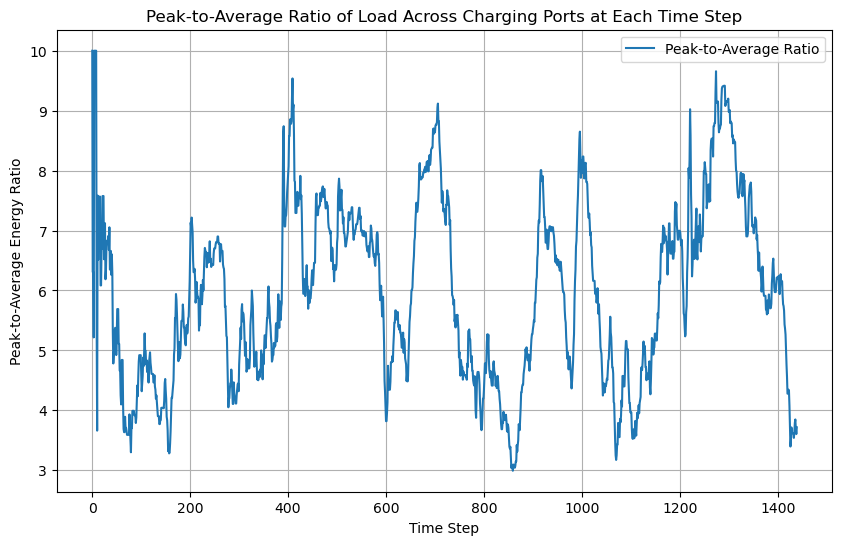

In [15]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import time

random.seed(17)
# Parameters
num_stations = 10  # Number of charging stations
station_capacity = 500  # Max capacity in KWh for each charging station
simulation_time = 1440 #Total simulation time steps
arrival_rate = 0.4 # Probability of EV arrival at each time step
charging_time_mean = 20 # Mean charging duration (time steps)
#charging_time_std = 10   # Std dev of charging duration


# Initialize charging stations
class ChargingStation:
    def __init__(self, station_id, capacity):
        self.station_id = station_id
        self.capacity = capacity
        self.current_load = 0
        self.ev_count = 0
        self.queue = deque()  # Queue to hold EVs being charged

    def add_ev(self, ev):
        self.queue.append(ev)
        self.current_load += ev.energy
        self.ev_count += 1

    def remove_ev(self):
        if self.queue:
            ev = self.queue.popleft()
            self.current_load -= ev.energy
            self.ev_count -= 1
            return ev
        return None

    def average_remaining_time(self):
        if self.ev_count == 0:
            return float(0)  # No EVs, so return a zero - No remaining time
        total_remaining_time = sum([ev.remaining_time for ev in self.queue])
        return total_remaining_time / self.ev_count

# EV class
class EV:
    def __init__(self, ev_id, energy, charging_duration, arrival_time):
        self.ev_id = ev_id
        self.energy = energy
        self.charging_duration = charging_duration
        self.remaining_time = charging_duration
        self.waiting_time = 1000
        self.arrival_time = arrival_time
        self.departure_time = None
        self.assigned_station = -1

    def charge_one_step(self):
        if self.remaining_time > 0:
            self.remaining_time -= 1
            if self.remaining_time == 0:
                self.departure_time = None  # To be set when removed from station

# Initialize stations
stations = [ChargingStation(i, station_capacity) for i in range(num_stations)]

# Simulation state
current_time = 0
ev_id_counter = 0
active_evs = []  # List to hold currently charging EVs
departed_evs = []  # List to hold departed EVs
par_list = []  # List to store peak-to-average ratio for each time step
par_time_list = [] # List to store peak-to-average waiting time ratio for each time step
served_evs_per_step = np.zeros(simulation_time)  # List to track the number of served EVs per time step
unassigned_evs_per_step = np.zeros(simulation_time)  # List to track the number of unassigned EVs per time step
arriving_evs_per_step = np.zeros(simulation_time)  # List to track the number of arriving EVs per time step
departing_evs_per_step = np.zeros(simulation_time)  # List to track the number of departing EVs per time step
waitingtimeseries = np.zeros(simulation_time)

# Function to calculate the peak-to-average ratio
def calculate_par(stations):
    loads = [station.current_load for station in stations]
    peak_load = max(loads)
    average_load = sum(loads) / len(stations)
    if average_load > 0:  # Avoid division by zero
        par = peak_load / average_load
    else:
        par = 0  # If average load is zero, PAR is not meaningful
    return par

# Function to calculate the peak-to-average ratio
def calculate_avgwaiting_time(evs):
    meantime = [np.mean(ev.waiting_time) for ev in evs]
    return meantime

def calculate_par_time(evs):
    loads = [np.mean(ev.waiting_time) for ev in evs]
    peak_load = max(loads)
    average_load = sum(loads) / len(evs)
    if average_load > 0:  # Avoid division by zero
        par = peak_load / average_load
        #par = loads
    else:
        par = 0  # If average load is zero, PAR is not meaningful
    return par

# Function to calculate the composite score for station selection
def calculate_station_score(station, ev_energy):
    current_load = station.current_load
    proximity_to_capacity = (current_load + ev_energy) / station.capacity  # How close to capacity
    avg_remaining_time = station.average_remaining_time()  # Avg time for current EVs to finish charging

    # Composite score: current load + penalty for proximity to capacity + benefit for short remaining times
    #score = current_load + proximity_to_capacity * 10 + avg_remaining_time * 10
    score = avg_remaining_time #Use the average waiting time only as my decision making criteria
    
    return score

def assign_ev_to_station(ev, stations):
    best_station = None
    best_score = float('inf')
    
    for station in stations:
        # Calculate the score for this station
        score = calculate_station_score(station, ev.energy)
        if random.uniform(0,1)>0.5:  # Ensure capacity limit
            best_score = score
            best_station = station
    
    # Assign to the best station
    if best_station is not None:
        best_station.add_ev(ev)
        ev.assigned_station = best_station.station_id
        ev.waiting_time = best_score
        return True  # EV was assigned successfully
    else:
        return False  # EV could not be assigned

timelist = []
stlist = []
loadlist = []
evlist = []

start_time = time.time()
# Simulation loop
for current_time in range(simulation_time):
    print(f"\n--- Time Step {current_time} ---")

    # 1. Handle EV departures
    departing_evs = 0
    for station in stations:
        if station.queue and station.queue[0].remaining_time <= 0:
            ev = station.remove_ev()
            ev.departure_time = current_time
            departed_evs.append(ev)
            active_evs.remove(ev)
            departing_evs += 1  # Track departing EVs
            print(f"EV {ev.ev_id} has departed from Station {station.station_id + 1}.")
            departing_evs_per_step[current_time] += 1

    #departing_evs_per_step.append(departing_evs)
    #departing_evs_per_step[current_time] += departing_evs

    # 2. Update remaining charging time for active EVs
    for ev in active_evs:
        ev.charge_one_step()

    # 3. Handle EV arrivals
    served_evs = 0
    unassigned_evs = 0
    arriving_evs = 0
    if np.random.poisson(arrival_rate) < arrival_rate: # Change this to a poisson RV
        energy = np.random.randint(10, 50)
        charging_duration = max(1, int(np.random.exponential(charging_time_mean))) # Change this to a Poisson service time too
        
        #charging_duration = max(1, int(10*energy/22)) # Deterministic service time depending on the charging rate (22 kW) and requested energy.
        
        # Start working on discrete event simulators (SimEvent) on MATLAB to trigger the arrival of EVs as events.
        # Synchronization is important between the arrivals clock and the services clock
        # If all the stations are not connected to the same feeder, then the idea of load balancing does not really apply.
        # (Add this as an assumption to my conference paper: Assume that all the stations are connected to the same power feeder to achieve the desired grid-related objective.)
        # Then I can plot peak-to-average ratio of the waiting time to assess the system rather than the peak-to-average energy ratio.
        # Should we consider batch queuing process or not?
        
        ev = EV(ev_id_counter, energy, charging_duration, current_time)
        ev_id_counter += 1
        active_evs.append(ev)
        arriving_evs += 1
        print(f"EV {ev.ev_id} has arrived with {ev.energy} KWh and needs {ev.charging_duration} time steps.")
        
        # Attempt to assign the EV to a station
        if assign_ev_to_station(ev, stations):
            served_evs += 1  # Successfully assigned
        else:
            unassigned_evs += 1  # Could not be assigned

    arriving_evs_per_step[current_time] += arriving_evs
    #served_evs_per_step[current_time] += served_evs
    unassigned_evs_per_step[current_time] += unassigned_evs

    # 4. Calculate peak-to-average ratio for this time step
    par = calculate_par(stations)
    par_list.append(par)  # Store PAR value for this time step
    par_time = calculate_par_time(active_evs) 
    par_time_list.append(par_time)
    waitingtimeseries[current_time] = np.mean(calculate_avgwaiting_time(active_evs))

    # 5. Display current state (optional)
    for station in stations:
        print(f"Station {station.station_id + 1}: Load={station.current_load} KWh, EVs={station.ev_count}")
        timelist.append(current_time)
        stlist.append(station.station_id + 1)
        loadlist.append(station.current_load)
        evlist.append(station.ev_count)
        current_loads = [station.current_load for station in stations]
        served_evs_per_step[current_time] += station.ev_count
    print(f"Number of EVs currently served is {served_evs_per_step[current_time]}")
    
end_time = time.time()

# Final Results
print("\n--- Simulation Completed ---\n")
for i, station in enumerate(stations):
    print(f"Station {i + 1} final load: {station.current_load} KWh, serving {station.ev_count} EVs.")
print(f"Total EVs Departed: {len(departed_evs)}")
print(f"Total EVs Active: {len(active_evs)}")
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
print(f"Average PAR for Station Energy across {simulation_time} steps is {np.mean(par_list)}.")
print(f"Average PAR Waiting Time across {simulation_time} steps is {np.mean(par_time_list)}.")
print(f"Average Waiting Time across {simulation_time} steps is {np.mean(waitingtimeseries)}.")

data = {'Time':range(simulation_time), 'PAR_Energy': par_list, 'PAR_Time': par_time_list, 'ArrivingEVs':arriving_evs_per_step, "DepartingEVs":departing_evs_per_step, "ServedEVs": served_evs_per_step, "UnassignedEVs":unassigned_evs_per_step}
import pandas as pd
DF = pd.DataFrame(data)
DF.to_csv('RandomAssignmentResults.csv', index=False)

# Plot Peak-to-Average Ratio over Time
plt.figure(figsize=(10, 6))
plt.plot(range(simulation_time), par_list, label='Peak-to-Average Ratio')
plt.xlabel('Time Step')
plt.ylabel('Peak-to-Average Energy Ratio')
plt.title('Peak-to-Average Ratio of Load Across Charging Ports at Each Time Step')
plt.legend()
plt.grid(True)
plt.savefig("PAER_Random.jpg")
plt.show()


In [17]:
df = pd.DataFrame({'Time': timelist, 'Station': stlist, 'Load': loadlist, 'EV_count':evlist})

In [19]:
df.to_csv("RandomAssignment_results_stepwise.csv", index=False)

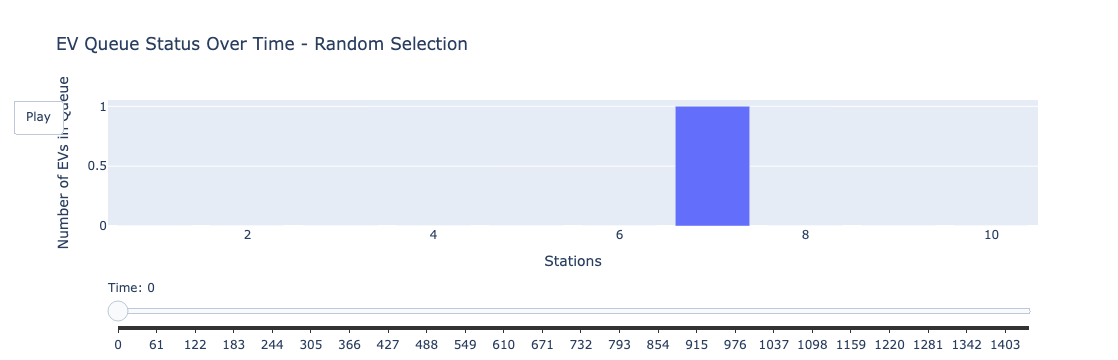

In [21]:
import plotly.graph_objects as go
import pandas as pd # Assuming your data is in a pandas DataFrame

# Sample Data Structure (replace with your actual data parsing)
# df should have columns like 'time', 'station', 'ev_count'
# For example:
# time | station | ev_count
# -----|---------|----------
# 1    | A       | 5
# 1    | B       | 3
# 2    | A       | 4
# 2    | B       | 6

# Assume 'df' is your DataFrame
times = sorted(df['Time'].unique())
stations = sorted(df['Station'].unique())

fig = go.Figure(
     data=[
         go.Bar(
             x=stations,
             y=df[df['Time'] == times[0]]['EV_count'], # Initial frame
             name='EVs Served'
         )
     ],
     layout=go.Layout(
         xaxis=dict(title='Stations'),
         yaxis=dict(title='Number of EVs in Queue'),
         title='EV Queue Status Over Time - Random Selection',
         updatemenus=[dict(
             type='buttons',
             showactive=False,
             buttons=[dict(label='Play',
                             method='animate',
                             args=[None, dict(frame=dict(duration=500, redraw=True), fromcurrent=True)])]
         )]
     ),
     frames=[
         go.Frame(
             data=[go.Bar(x=stations, y=df[df['Time'] == t]['EV_count'])],
             name=str(t) # Frame name
         ) for t in times
     ]
 )

fig.update_layout(
     sliders=[dict(
         steps = [dict(method='animate', args=[[str(t)], dict(mode='immediate', frame=dict(duration=500, redraw=True), transition=dict(duration=0))], label=str(t)) for t in times],
         active = 0,
         currentvalue = {"prefix": "Time: "},
         pad = {"t": 50}
     )]
 )

fig.show()

In [23]:
import plotly.io as pio
pio.write_html(fig, file='interactive_Random.html', auto_open=True)